In [5]:
# Bayesian online changepoint detection (BOCD)
# Based on @gwgundersen's work: https://github.com/gwgundersen
# Author: Gerardo Duran-Martin (@gerdm)
import jax
import jax.numpy as jnp
from jax.scipy import stats
from functools import partial
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

In [6]:
# import os
# os.environ["LATEXIFY"] = ""
pml.latexify()

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [7]:
class GMM:
    def __init__(self, transition_matrix, means, precisions):
        self.transition_matrix = transition_matrix
        self.n_states, _ = transition_matrix.shape
        self.means = means
        self.precisions = precisions * jnp.ones(self.n_states)

    def _step_hmm(self, key, s_prev):
        p_transition = self.transition_matrix[s_prev, :]
        s_next = jax.random.choice(key, self.n_states, p=p_transition)
        return s_next

    def _step_process(self, s_prev, key):
        key_obs, key_step = jax.random.split(key)

        s_next = self._step_hmm(key_step, s_prev)
        mean = self.means[s_next]
        precision = self.precisions[s_next]
        obs_next = jax.random.normal(key_obs) / precision + mean

        output = {
            "latent": s_next,
            "observed": obs_next,
        }

        return s_next, output

    def sample(self, key, T):
        key_init, key_steps = jax.random.split(key)
        keys = jax.random.split(key_steps, T)
        s_init = jax.random.choice(key_init, self.n_states)
        _, outputs = jax.lax.scan(self._step_process, s_init, keys)
        return outputs


class BOCD:
    """
    Bayesian online changepoint detection (BOCD) implementation
    for a a univariate gaussian process with fixed precision and
    varying mean.
    """

    def __init__(self, mu0, lambda0, lambda_data, hazard):
        self.mu0 = mu0
        self.lambda0 = lambda0
        self.lambda_data = lambda_data
        self.hazard = hazard
        self.run_length_pred = jax.vmap(self.run_length_pred, (None, 0, 0))

    def run_length_pred(self, x, mean, prec):
        return stats.norm.logpdf(x, mean, jnp.sqrt(1 / prec + 1))

    def __call__(self, X):
        T = len(X)
        init_state = {
            "time": 0,
            "mean": jnp.zeros(T).at[0].set(self.mu0),
            "precision": jnp.zeros(T).at[0].set(self.lambda0),
            "log_pred": jnp.zeros(T),
            "suff_stat": jnp.zeros(T),
        }

        bocd_step = partial(self.__bocd_step, timesteps=jnp.arange(T))
        final_state, pred = jax.lax.scan(bocd_step, init_state, X)
        return final_state, pred

    def __bocd_step(self, state, xt, timesteps):
        time = state["time"]
        prec_old = state["precision"][time]
        time_select = timesteps <= time
        state["suff_stat"] = jnp.roll(state["suff_stat"], 1) + xt * time_select

        log_predictive_run_length = self.run_length_pred(xt, state["mean"], state["precision"])

        pred_new_0 = jax.nn.logsumexp(state["log_pred"] + log_predictive_run_length + jnp.log(self.hazard))
        pred_new = state["log_pred"] + log_predictive_run_length + jnp.log((1 - self.hazard))

        state["log_pred"] = jnp.r_[pred_new_0, pred_new[:-1]]
        state["log_pred"] = state["log_pred"] - jax.nn.logsumexp(state["log_pred"])

        prec_new = self.lambda_data + prec_old
        state["time"] = state["time"] + 1
        state["precision"] = state["precision"].at[time + 1].set(prec_new)
        state["mean"] = (self.mu0 / self.lambda0 + state["suff_stat"] / self.lambda_data) / state["precision"]
        state["mean"] = state["mean"] * time_select

        return state, state["log_pred"]


def plot_gmm_changepoints(ax, gmm_output, timesteps=None):
    X = gmm_output["observed"]
    states = gmm_output["latent"]
    n_states = len(jnp.unique(states))
    T = len(X)
    timesteps = jnp.arange(T) if timesteps is None else timesteps

    ax[0].plot(timesteps, X, marker="o", markersize=1.5, linewidth=1, c="tab:gray")

    ax[1].scatter(timesteps, states, c="tab:gray")
    ax[1].set_yticks(jnp.arange(n_states))
    for y in range(n_states):
        ax[1].axhline(y=y, c="tab:gray", alpha=0.3)

    for changepoint, axi in product(changepoints, ax):
        axi.axvline(x=changepoint, c="tab:red", linestyle="dotted")

    for axi in ax:
        axi.set_xlim(timesteps[0], timesteps[-1])

    # plt.tight_layout()


def plot_bocd_changepoints(ax, X, posterior_predictive, changepoints, timesteps=None):
    T = len(X)
    timesteps = jnp.arange(T) if timesteps is None else timesteps

    r_max = posterior_predictive.argmax(axis=1).max()
    ax[1].plot(posterior_predictive.argmax(axis=1), c="tab:red", linewidth=1)
    ax[1].imshow(jnp.rot90(posterior_predictive, k=3)[:, ::-1], origin="lower", aspect="auto", cmap="bone_r")

    ax[0].plot(timesteps, X, marker="o", markersize=1, linewidth=1, c="tab:gray")

    ax[0].set_xlim(0, T)
    ax[1].set_xlim(0, T)
    if changepoints is not None:
        for changepoint, axi in product(changepoints, ax):
            axi.axvline(x=changepoint, c="tab:red", linestyle="dotted")

    ax[1].set_ylim(0, r_max)

    # plt.tight_layout()

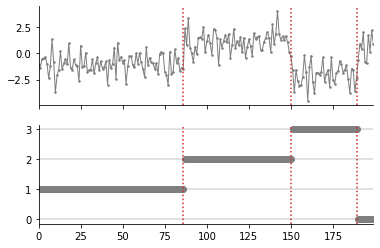

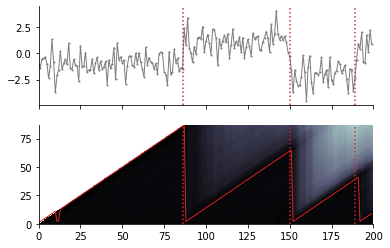

In [8]:
key = jax.random.PRNGKey(27182)


T = 200
# means = jnp.array([0, -5, 3, -2])
means = jnp.array([0, -1, 1, -2])  # closer together (harder)
precision = 1
p_stay = 0.97
p_move = 1 - p_stay
transition_matrix = jnp.array(
    [
        [p_stay, p_move, 0.0, 0.0],
        [0.0, p_stay, p_move, 0.0],
        [0.0, 0.0, p_stay, p_move],
        [p_move, 0.0, 0.0, p_stay],
    ]
)

gmm = GMM(transition_matrix, means, precision)
gmm_output = gmm.sample(key, T)
changepoints, *_ = jnp.where(jnp.diff(gmm_output["latent"]) != 0)

mu_hat, lambda_hat = 0, 1.0
hazard = len(changepoints) / T
bocd = BOCD(mu_hat, lambda_hat, precision, hazard)
_, bocd_post_predictive = bocd(gmm_output["observed"])

# fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex="all")
fig, ax = plt.subplots(2, 1, sharex="all")

plot_gmm_changepoints(ax, gmm_output)
sns.despine()
pml.savefig("bocd-changepoints-truth.pdf")

# fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex="all")
fig, ax = plt.subplots(2, 1, sharex="all")

plot_bocd_changepoints(ax, gmm_output["observed"], bocd_post_predictive, changepoints)
sns.despine()
pml.savefig("bocd-changepoints-estimated.pdf")